In [ ]:
!pip install --upgrade tensorflow

In [104]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [79]:
# Load the train data and labels from the text file
train_data = []
train_labels = []
with open('/content/Earthquakes_TRAIN.arff') as file:
    for line in file:
        line = line.strip().split(',')
        # print(line)
        train_data.append(line[:-1])
        train_labels.append(line[-1])
train_data = np.array(train_data, dtype=float)
train_labels = np.array(train_labels)


# Load the test data and labels from the text file
test_data = []
test_labels = []
with open('/content/Earthquakes_TEST.arff') as file:
    for line in file:
        line = line.strip().split(',')
        test_data.append(line[:-1])
        test_labels.append(line[-1])
test_data = np.array(test_data, dtype=float)
test_labels = np.array(test_labels)

In [80]:
train_labels = train_labels.astype('float32')
test_labels = test_labels.astype('float32')

In [65]:
print(np.shape(train_data), np.shape(test_data))
print(len(train_labels),len(test_labels))
# print(train_data)

(322, 512) (139, 512)
322 139


In [81]:
# Perform undersampling on the training data
# sampler = RandomUnderSampler(random_state=42)
# sampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
# train_data_resampled, train_labels_resampled = sampler.fit_resample(train_data, train_labels)

In [82]:
# print(len(train_labels_resampled))

528


In [57]:
# Calculate class weights
num_neg = np.sum(train_labels == 0)
num_pos = np.sum(train_labels == 1)
total = num_neg + num_pos
# class_weight = {0: total / num_neg, 1: total / num_pos}
class_weight = {0: 0.2, 1: 0.8}

In [99]:
# Reshape the data to fit the LSTM input shape
train_data = train_data.reshape((322, 512, 1))
test_data = test_data.reshape((139, 512, 1))

# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(64, input_shape=(512, 1)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 64)                16896     
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
None


In [101]:
# Train the model
model.fit(train_data, train_labels, epochs=10, validation_data=(test_data, test_labels))#, class_weight=class_weight)
# model.fit(train_data_resampled, train_labels_resampled, epochs=10, validation_data=(test_data, test_labels))

Epoch 1/10
11/11 [==============================] - 4s 414ms/step - loss: 0.6527 - accuracy: 0.7733 - val_loss: 0.6068 - val_accuracy: 0.7266
Epoch 2/10
11/11 [==============================] - 3s 274ms/step - loss: 0.5349 - accuracy: 0.8168 - val_loss: 0.6745 - val_accuracy: 0.7554
Epoch 3/10
11/11 [==============================] - 2s 220ms/step - loss: 0.4924 - accuracy: 0.8230 - val_loss: 0.5201 - val_accuracy: 0.7626
Epoch 4/10
11/11 [==============================] - 2s 217ms/step - loss: 0.4582 - accuracy: 0.8230 - val_loss: 0.5287 - val_accuracy: 0.7554
Epoch 5/10
11/11 [==============================] - 3s 296ms/step - loss: 0.4510 - accuracy: 0.8261 - val_loss: 0.5316 - val_accuracy: 0.7554
Epoch 6/10
11/11 [==============================] - 3s 239ms/step - loss: 0.4513 - accuracy: 0.8230 - val_loss: 0.5406 - val_accuracy: 0.7554
Epoch 7/10
11/11 [==============================] - 2s 218ms/step - loss: 0.4484 - accuracy: 0.8230 - val_loss: 0.5277 - val_accuracy: 0.7554
Epoch 

In [102]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_data, test_labels)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

5/5 [==============================] - 0s 60ms/step - loss: 0.5109 - accuracy: 0.7698
Test loss: 0.5109329223632812
Test accuracy: 0.769784152507782


5/5 [==============================] - 1s 98ms/step


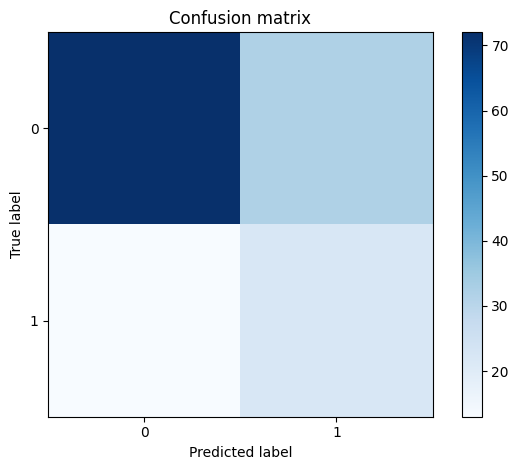

In [130]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef, f1_score, recall_score, precision_score

# Make predictions on test data
# y_pred = np.round(model.predict(test_data)).astype(int)
y_pred_prob = model.predict(test_data)
y_pred = (y_pred_prob > 0.225).astype(int)

# Compute confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()


In [131]:
# Compute the evaluation metrics
mcc = matthews_corrcoef(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print(f'Accuracy: {accuracy:.3f}')
print(f'MCC: {mcc:.3f}')
print(f'F1 score: {f1:.3f}')
print(f'Recall: {recall:.3f}')
print(f'Precision: {precision:.3f}')

Accuracy: 0.770
MCC: 0.286
F1 score: 0.494
Recall: 0.629
Precision: 0.407


5/5 [==============================] - 1s 122ms/step


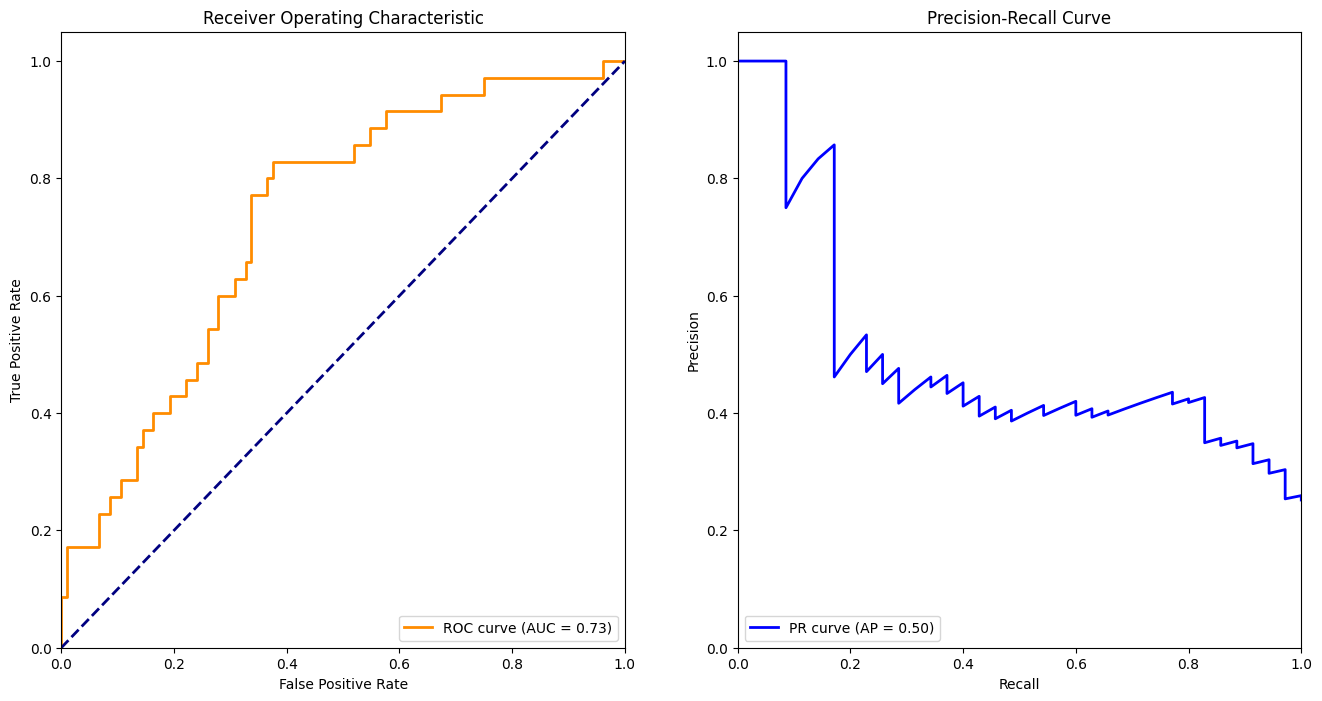

In [136]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Predict the test examples and compute the predicted probabilities
y_pred_prob = model.predict(test_data)

# Compute the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# calculate PR curve and average precision
precision, recall, _ = precision_recall_curve(test_labels, y_pred_prob)
average_precision = average_precision_score(test_labels, y_pred_prob)

# plot ROC curve and AUC
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# plot PR curve and average precision
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (AP = %0.2f)' % average_precision)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.show()

# # Plot the ROC curve
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic (ROC) curve')
# plt.legend(loc="lower right")
# plt.show()


In [126]:
from sklearn.metrics import classification_report

# Predict the test examples and compute the predicted probabilities
y_pred_prob = model.predict(test_data)

# Compute the F1 score, precision, and recall for the default threshold (0.5)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)
print('Default threshold (0.5):\n')
print(classification_report(test_labels, y_pred))

# Adjust the threshold to 0.4
y_pred = np.where(y_pred_prob > 0.4, 1, 0)
print('Threshold of 0.4:\n')
print(classification_report(test_labels, y_pred))


5/5 [==============================] - 0s 55ms/step
Default threshold (0.5):

              precision    recall  f1-score   support

         0.0       0.78      0.97      0.86       104
         1.0       0.67      0.17      0.27        35

    accuracy                           0.77       139
   macro avg       0.72      0.57      0.57       139
weighted avg       0.75      0.77      0.71       139

Threshold of 0.4:

              precision    recall  f1-score   support

         0.0       0.78      0.92      0.85       104
         1.0       0.50      0.23      0.31        35

    accuracy                           0.75       139
   macro avg       0.64      0.58      0.58       139
weighted avg       0.71      0.75      0.71       139

